In [1]:
import copy

from hydradx.model.processing import get_omnipool_data, get_binance_orderbook, get_kraken_orderbook, get_omnipool, load_omnipool, save_omnipool
from hydradx.model.amm.omnipool_amm import OmnipoolState
from hydradx.model.amm.centralized_market import CentralizedMarket
from hydradx.model.amm.agents import Agent

import matplotlib.pyplot as plt

from pprint import pprint
from mpmath import mpf, mp
mp.dps = 50

from hydradxapi import HydraDX


In [2]:

RPC="wss://rpc.hydradx.cloud"
            
# asset_list, asset_map, tokens, fees = get_omnipool_data(RPC, archive=False)



In [3]:
# pprint(asset_list)

In [4]:
get_live_markets = True

if get_live_markets:
    init_omnipool = get_omnipool()
else:
    init_omnipool = load_omnipool()
omnipool = copy.deepcopy(init_omnipool)

In [5]:
# save = True
# if save:
#     save_omnipool(omnipool)

In [6]:
pprint(omnipool)
for tkn in omnipool.sub_pools["2-Pool102"].asset_list:
    omnipool.sub_pools["2-Pool102"].liquidity[tkn] *= 10
omnipool.lrna["2-Pool102"] *= 10

Omnipool: omnipool
********************************
tvl cap: inf
LRNA imbalance: 0.0
lrna fee:

    4-Pool: 0.05%
    HDX: 0.1%
    WETH: 0.05%
    2-Pool101: 0.05%
    GLMR: 0.05%
    BNC: 0.05%
    vDOT: 0.05%
    CFG: 0.05%
    2-Pool102: 0.05%
    DOT: 0.05059999999999999%
    PHA: 0.05%
    ZTG: 0.05%
    INTR: 0.0503%
    ASTR: 0.05%

asset fee:

    4-Pool: 0.2569%
    HDX: 0.25%
    WETH: 0.25%
    2-Pool101: 0.25%
    GLMR: 0.262%
    BNC: 0.25%
    vDOT: 0.25%
    CFG: 0.3485%
    2-Pool102: 0.2908%
    DOT: 0.3156%
    PHA: 0.25%
    ZTG: 0.25%
    INTR: 0.25%
    ASTR: 0.25%

asset pools: (

    *4-Pool*
    asset quantity: 1579316.0233407225
    lrna quantity: 39783.674606756475
    USD price: 1.008592839092
    tvl: $1592886.8318046862
    weight: 39783.674606756475/575248.3725987811 (0.06915912586945192)
    weight cap: 1
    total shares: 1579316.0233407225
    protocol shares: 1579316.0233407225

    *HDX*
    asset quantity: 49587424.30497615
    lrna quantity: 43467.

In [7]:
cex_asset_tkn = "DOT"
cex_denom_tkn = "USD"
dex_asset_tkn = "DOT"
dex_denom_tkn = "USDT10"
one_hop = False
cex_fee_list = [0.0, 0.001, 0.0016, 0.002, 0.0026]
cex_dict = {}
for cex_fee in cex_fee_list:
    try:
        kraken_ob = get_kraken_orderbook((cex_asset_tkn, cex_denom_tkn), archive=False)
        cex = CentralizedMarket(
            order_book={(cex_asset_tkn, cex_denom_tkn): kraken_ob},
            asset_list=[cex_asset_tkn, cex_denom_tkn],
            trade_fee=cex_fee
        )
        one_hop = True
    except:  # orderbook doesn't exist? try going through USD
        asset_ob = get_kraken_orderbook((cex_asset_tkn, "USD"), archive=False)
        denom_ob = get_kraken_orderbook((cex_denom_tkn, "USD"), archive=False)
        cex = CentralizedMarket(
            order_book={(cex_asset_tkn, "USD"): asset_ob, (cex_denom_tkn, "USD"): denom_ob},
            asset_list=[cex_asset_tkn, cex_denom_tkn, "USD"],
            trade_fee=cex_fee
        )
    cex_dict[cex_fee] = cex
cex = cex_dict[0.0]

In [8]:
from hydradx.model.amm.omnipool_amm import lrna_price

if one_hop:
    cex_spot = (cex.order_book[(cex_asset_tkn, cex_denom_tkn)].bids[0][0] + cex.order_book[(cex_asset_tkn, cex_denom_tkn)].asks[0][0]) / 2
else:
    cex_asset_spot = (cex.order_book[(cex_asset_tkn, "USD")].bids[0][0] + cex.order_book[(cex_asset_tkn, "USD")].asks[0][0]) / 2
    cex_denom_spot = (cex.order_book[(cex_denom_tkn, "USD")].bids[0][0] + cex.order_book[(cex_denom_tkn, "USD")].asks[0][0]) / 2
    cex_spot = cex_asset_spot / cex_denom_spot


# dex_denom_data = tokens[dex_denom_tkn]
# dex_denom_scale = mpf(1)
# overall_scale = mpf(1)
# dex_denom_lrna = dex_denom_data['LRNA'] * dex_denom_scale * overall_scale
# dot_liquidity = tokens[dex_asset_tkn]['liquidity'] * overall_scale
# dot_lrna = tokens[dex_asset_tkn]['LRNA'] * overall_scale
# dex_denom_liquidity = cex_spot * dex_denom_lrna * dot_liquidity / dot_lrna
# dex_denom_data_up = {'LRNA': dex_denom_lrna, 'liquidity': dex_denom_liquidity}
# hdx_data = {'LRNA': tokens['HDX']['LRNA'] * overall_scale, 'liquidity': tokens['HDX']['liquidity'] * overall_scale}
# dot_data = {'LRNA': dot_lrna, 'liquidity': dot_liquidity}

# op_state = OmnipoolState(
#     # tokens={dex_denom_tkn: dex_denom_data_up, dex_asset_tkn: dot_data, "HDX": hdx_data,
#     #         "USD": {"LRNA": mpf(10000), "liquidity": mpf(10000)}},
#     tokens=tokens,
#     preferred_stablecoin="USDT",
#     lrna_fee=0.0000,
#     asset_fee=0.0000
# )
op_state = omnipool.copy()

protocol_agent = Agent(holdings={"DOT": mpf(500000)})
op_state.add_liquidity(protocol_agent, 500000, "DOT")

# protocol_agent = Agent(holdings={"DOT": mpf(500000)})
# op_state.add_liquidity(protocol_agent, 500000, "DOT")


op_state.asset_fee = 0.0025
op_state.lrna_fee = 0.0005

op_state.asset_fee = 0.00
op_state.lrna_fee = 0.00

    
# pprint(tokens)
print(op_state.liquidity)    
print(op_state.sub_pools["2-Pool102"].liquidity)
print(op_state.sub_pools["2-Pool102"].share_price("USDT10"))
print(lrna_price(op_state, "2-Pool102"))
print(lrna_price(op_state, "DOT"))
print(op_state.sub_pools["2-Pool102"].share_price("USDT10") / lrna_price(op_state, "2-Pool102") * lrna_price(op_state, "DOT"))
print(op_state.usd_price(op_state, "DOT"))
    

{'4-Pool': 1579316.0233407225, 'HDX': 49587424.30497615, 'WETH': 1097.5836962960757, '2-Pool101': 53.80014600206344, 'GLMR': 690973.8362588404, 'BNC': 564778.7672962573, 'vDOT': 245232.5285811055, 'CFG': 1002829.2000587007, '2-Pool102': 4463032.472660727, 'DOT': 1189978.4656414785, 'PHA': 1170915.989145525, 'ZTG': 1992391.924156925, 'INTR': 14936523.620828468, 'ASTR': 2759526.8351247166}
{'USDT10': 23073100.83845, 'USDC22': 21761700.278070003}
10.002859246068699
0.24982973644895926
0.17468173563549302
6.994030571608117
6.994030571608116


In [9]:
op_spot = op_state.price(op_state, dex_asset_tkn, dex_denom_tkn, denom_pool_id="2-Pool102")
pprint(op_spot)
pprint(cex_spot)
# pprint((cex.order_book[(cex_asset_tkn, cex_denom_tkn)].bids[0][0],cex.order_book[(cex_asset_tkn, cex_denom_tkn)].asks[0][0]))
# pprint((cex.order_book[(cex_asset_tkn, cex_denom_tkn)].asks[0][0] - cex.order_book[(cex_asset_tkn, cex_denom_tkn)].bids[0][0])/cex.order_book[(cex_asset_tkn, cex_denom_tkn)].bids[0][0])

6.994030571608116
6.98315


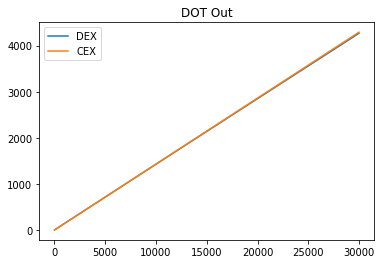

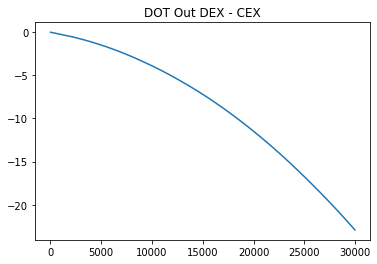

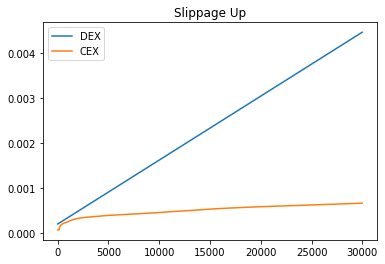

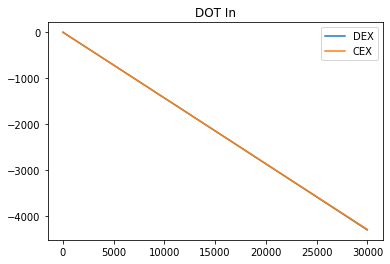

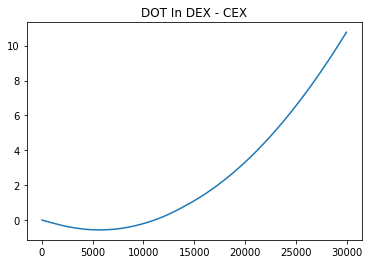

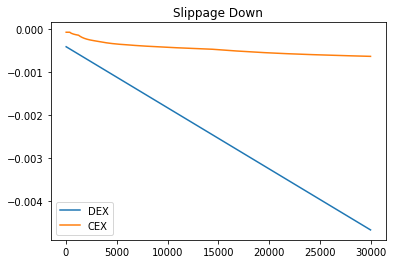

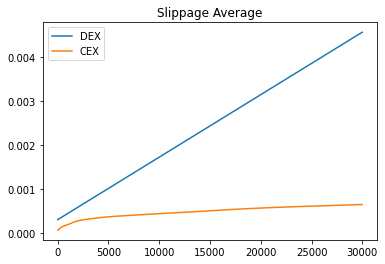

In [10]:
asset_spot = omnipool.price(omnipool, dex_denom_tkn, "USDT10", denom_pool_id="2-Pool102")
asset_spot = 1
init_price = omnipool.price(omnipool, dex_asset_tkn, dex_denom_tkn, denom_pool_id="2-Pool102")
dollar_step_size = 20
iters = 1500
max_amt = dollar_step_size * iters

holdings = {
    cex_denom_tkn: mpf(max_amt * 2),
    dex_denom_tkn: mpf(max_amt * 2),
    cex_asset_tkn: mpf(max_amt * 2 / init_price),
    dex_asset_tkn: mpf(max_amt * 2 / init_price),
    "USD": mpf(max_amt * 2 * asset_spot)
}
for tkn in [cex_asset_tkn, cex_denom_tkn, dex_asset_tkn, dex_denom_tkn, "USD"]:
    if tkn not in holdings:
        holdings[tkn] = mpf(10000000)
agent = Agent(holdings=holdings)

trade_size_list = [dollar_step_size/asset_spot*i for i in range(1, iters)]
dot_out_cex = []
dot_out_dex = []
dot_in_cex = []
dot_in_dex = []
slip_up_dex = []
slip_up_cex = []
slip_down_dex = []
slip_down_cex = []
slip_avg_dex = []
slip_avg_cex = []
for trade_size in trade_size_list:
    temp_op_state = op_state.copy()
    temp_agent1 = agent.copy()
    temp_op_state.swap(temp_agent1, tkn_buy=dex_asset_tkn, tkn_sell=dex_denom_tkn, sell_quantity=trade_size, tkn_sell_subpool_id="2-Pool102")
    dot_out_dex.append(temp_agent1.holdings[dex_asset_tkn] - agent.holdings[dex_asset_tkn])
    exec_price_dex = trade_size / (temp_agent1.holdings[dex_asset_tkn] - agent.holdings[dex_asset_tkn])
    slip_up_dex.append((abs(exec_price_dex) - op_spot) / op_spot) 


    temp_cex_state = cex.copy()
    temp_agent2 = agent.copy()
    if one_hop:
        temp_cex_state.swap(temp_agent2, tkn_buy=cex_asset_tkn, tkn_sell=cex_denom_tkn, sell_quantity=trade_size)
    else:
        temp_cex_state.swap(temp_agent2, tkn_buy="USD", tkn_sell=cex_denom_tkn, sell_quantity=trade_size)
        sell_amt_usd = temp_agent2.holdings["USD"] - agent.holdings["USD"]
        temp_cex_state.swap(temp_agent2, tkn_buy=cex_asset_tkn, tkn_sell="USD", sell_quantity=sell_amt_usd)
    dot_out_cex.append(temp_agent2.holdings[cex_asset_tkn] - agent.holdings[cex_asset_tkn])
    exec_price_cex = trade_size / (temp_agent2.holdings[cex_asset_tkn] - agent.holdings[cex_asset_tkn])
    slip_up_cex.append((abs(exec_price_cex) - cex_spot) / cex_spot)
    # pprint((slip_up_dex[-1], slip_up_cex[-1]))

    temp_op_state = op_state.copy()
    temp_agent1 = agent.copy()
    temp_op_state.swap(temp_agent1, tkn_sell=dex_asset_tkn, tkn_buy=dex_denom_tkn, buy_quantity=trade_size, tkn_buy_subpool_id="2-Pool102")
    dot_in_dex.append(temp_agent1.holdings[dex_asset_tkn] - agent.holdings[dex_asset_tkn])
    exec_price_dex = trade_size / (temp_agent1.holdings[dex_asset_tkn] - agent.holdings[dex_asset_tkn])
    slip_down_dex.append((abs(exec_price_dex) - op_spot) / op_spot) 
    
    temp_cex_state = cex.copy()
    temp_agent2 = agent.copy()
    if one_hop:
        temp_cex_state.swap(temp_agent2, tkn_sell=cex_asset_tkn, tkn_buy=cex_denom_tkn, buy_quantity=trade_size)
    else:
        temp_cex_state.swap(temp_agent2, tkn_sell="USD", tkn_buy=cex_denom_tkn, buy_quantity=trade_size)
        sell_amt_usd = temp_agent2.holdings["USD"] - agent.holdings["USD"]
        temp_cex_state.swap(temp_agent2, tkn_sell=cex_asset_tkn, tkn_buy="USD", buy_quantity=sell_amt_usd)
    dot_in_cex.append(temp_agent2.holdings[cex_asset_tkn] - agent.holdings[cex_asset_tkn])
    exec_price_cex = trade_size / (temp_agent2.holdings[cex_asset_tkn] - agent.holdings[cex_asset_tkn])
    slip_down_cex.append((abs(exec_price_cex) - cex_spot) / cex_spot)
    
    slip_avg_dex.append((abs(slip_up_dex[-1]) + abs(slip_down_dex[-1])) / 2)
    slip_avg_cex.append((abs(slip_up_cex[-1]) + abs(slip_down_cex[-1])) / 2)
    # pprint((slip_up_dex[-1], slip_up_cex[-1]))
    
plt.plot(trade_size_list, dot_out_dex, label="DEX")
plt.plot(trade_size_list, dot_out_cex, label="CEX")
plt.legend()
plt.title("DOT Out")
plt.show()

diffs = [dot_out_dex[i] - dot_out_cex[i] for i in range(len(dot_out_dex))]
plt.plot(trade_size_list, diffs, label="DEX - CEX")
plt.title("DOT Out DEX - CEX")
plt.show()

plt.plot(trade_size_list, slip_up_dex, label="DEX")
plt.plot(trade_size_list, slip_up_cex, label="CEX")
plt.legend()
plt.title("Slippage Up")
plt.show()

plt.plot(trade_size_list, dot_in_dex, label="DEX")
plt.plot(trade_size_list, dot_in_cex, label="CEX")
plt.legend()
plt.title("DOT In")
plt.show()

diffs2 = [dot_in_cex[i] - dot_in_dex[i] for i in range(len(dot_in_dex))]
plt.plot(trade_size_list, diffs2, label="DEX - CEX")
plt.title("DOT In DEX - CEX")
plt.show()

plt.plot(trade_size_list, slip_down_dex, label="DEX")
plt.plot(trade_size_list, slip_down_cex, label="CEX")
plt.legend()
plt.title("Slippage Down")
plt.show()

plt.plot(trade_size_list, slip_avg_dex, label="DEX")
plt.plot(trade_size_list, slip_avg_cex, label="CEX")
plt.legend()
plt.title("Slippage Average")
plt.show()

# print(cex.order_book)

In [11]:
print(dot_out_cex[-1])

4290.3561314867010878515429794788360595703125


In [12]:
print(dot_out_dex[-1])

4267.4324307316192061989568173885345458984375
